# Part 1: Validation of Series–Parallel (SP) Diploid Construction

## Objective
Validate the diploid expansion procedure on SP graph examples.

## Methodology
* **Input:** Use SP graph examples, starting from small bubbles and moving to slightly more complex cases.
* **Decomposition:** Build the SPQR-tree, root it at the Q-node to connect the graph terminals, and identify all P-nodes.
* **Expansion:** Apply the diploid expansion rules at each P-node.
* **Validation:** Visualize the final diploid graphs and compare haploid vs. diploid sizes to show how expansion only at P-nodes leads to efficient growth.

>>> PIPELINE STARTED

--- 1. Input Haploid Graph ---


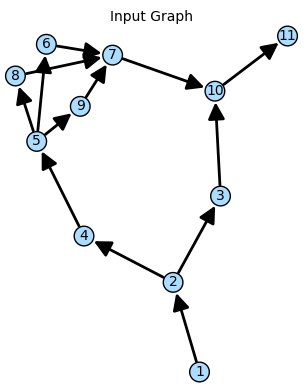

--- Analyzing SPQR Components ---
  > Found P-node (Bubble) at terminals: [2, 10]
  > Found P-node (Bubble) at terminals: [5, 7]

--- 2. SPQR Tree Decomposition ---


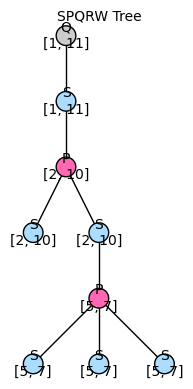


--- Expanding Diploid Graph ---
  Processing P at 2-10...
    Added 6 diploid nodes.
  Processing P at 5-7...
    Added 6 diploid nodes.

--- 3. Diploid Graph (With Path Pair Labels) ---


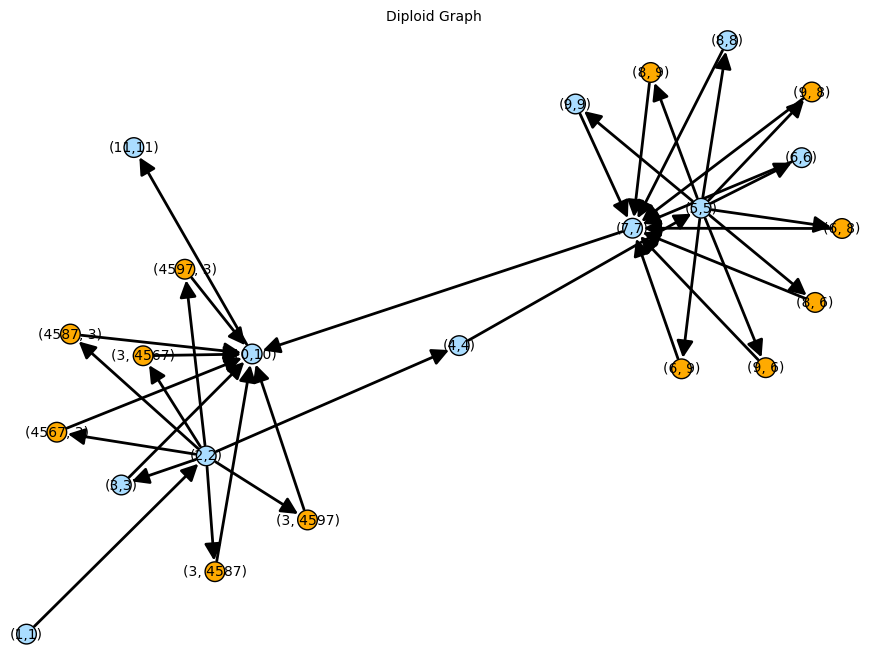


        GRAPH SIZE REPORT        
Input Stats: 11 nodes, 13 edges
Diploid Stats: 23 nodes, 37 edges
Node Expansion: 2.09x
Edge Expansion: 2.85x


In [2]:
# ============================================================
# 1. IMPORTS
# ============================================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import traceback
import sys

# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def get_shared_vertices(g1, g2):
    """
    Return vertices shared between two Sage graph objects.
    Used to identify the 'split pair' (terminals) between components.
    """
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    shared = list(v1.intersection(v2))
    return shared

def find_all_paths(G, s, t):
    """Return all simple paths from s to t (length > 1)."""
    paths = []
    for p in G.all_paths(s, t):
        if len(p) > 1:
            paths.append(tuple(p))
    return paths

def format_path_label(path):
    """
    Converts path tuple to string label.
    (2, 5, 6, 7, 10) -> "567"
    """
    internals = path[1:-1]
    if not internals:
        return "-"
    return "".join(str(n) for n in internals)

# ============================================================
# 3. SPQR DECOMPOSITION
# ============================================================
def analyze_canonical_spqr(G, source_node, sink_node):
    G_multi = Graph(G.to_undirected(), multiedges=True)
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label="REFERENCE_EDGE")

    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()

    # Locate root
    root_component = None
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        if source_node in subgraph and sink_node in subgraph:
            if subgraph.has_edge(source_node, sink_node):
                root_component = node; break
    if root_component is None:
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                root_component = node; break
    if root_component is None: raise ValueError("Root not found.")

    # Build tree
    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    queue = [(root_component, root_q)]; visited = {root_component}; all_nodes = [root_q]; counter = 0

    print(f"--- Analyzing SPQR Components ---")

    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        final_type = curr_type
        if curr_type == 'R' and curr_subgraph.order() > 2: final_type = 'W'

        # Determine Terminals
        if parent_display['id'] == 'ROOT_Q': 
            terms = [source_node, sink_node]
        else:
            parent_sage_obj = next(n['sage_obj'] for n in all_nodes if n['id'] == parent_display['id'])
            terms = get_shared_vertices(curr_subgraph, parent_sage_obj)
            
            # ERROR CHECK: If we can't find shared vertices, the tree logic is broken
            if not terms or len(terms) != 2:
                # In standard SPQR, components share exactly 2 vertices (the split pair)
                # If this fails, we log it but don't fallback to global S,T to avoid wrong expansion
                print(f"Warning: Could not find 2 shared terminals for {final_type} node. Found: {terms}")
                # Fallback only if truly empty (should not happen in valid SPQR)
                if not terms: terms = [source_node, sink_node]

        node_id = f"{final_type}_{counter}"
        counter += 1
        display_node = {'id': node_id, 'type': final_type, 'terminals': terms, 'sage_obj': curr_subgraph, 'parent_id': parent_display['id']}
        all_nodes.append(display_node)
        
        if final_type == 'P':
            print(f"  > Found P-node (Bubble) at terminals: {terms}")

        for nbr in T.neighbor_iterator(curr_sage):
            if nbr not in visited:
                visited.add(nbr); queue.append((nbr, display_node))
    return all_nodes

# ============================================================
# 4. DIPLOID CONSTRUCTION
# ============================================================
def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    display_labels = {} 

    # 1. Backbone
    for v in G.vertices(sort=False): 
        GD.add_vertex((v, v))
        display_labels[(v, v)] = f"({v},{v})"

    for u, v, l in G.edges(sort=False): 
        GD.add_edge((u, u), (v, v), label="backbone")

    # 2. Expansion
    print(f"\n--- Expanding Diploid Graph ---")
    for node in spqr_nodes:
        if node["type"] not in ["P", "W"]: continue
        s, t = node["terminals"]
        
        # DEBUG: Verify we are processing the node
        print(f"  Processing {node['type']} at {s}-{t}...")
        
        all_paths = find_all_paths(G, s, t)
        
        if len(all_paths) < 2: 
            print(f"    Skipping: Found {len(all_paths)} paths (need >=2)")
            continue

        count = 0
        for i in range(len(all_paths)):
            P1 = all_paths[i]
            set_p1 = set(P1[1:-1])
            for j in range(len(all_paths)):
                if i == j: continue
                P2 = all_paths[j]
                set_p2 = set(P2[1:-1])
                
                if set_p1.isdisjoint(set_p2):
                    count += 1
                    pair_id = hash((P1, P2)) % 100000
                    het_node = f"Het_{node['type']}_{pair_id}"
                    
                    GD.add_vertex(het_node)
                    GD.add_edge((s, s), het_node)
                    GD.add_edge(het_node, (t, t))

                    str_p1 = format_path_label(P1)
                    str_p2 = format_path_label(P2)
                    display_labels[het_node] = f"({str_p1}, {str_p2})"
        print(f"    Added {count} diploid nodes.")

    return GD, display_labels

# ============================================================
# 5. VISUALIZATION FUNCTIONS
# ============================================================
def visualize_input_graph(G):
    print("\n--- 1. Input Haploid Graph ---")
    G.show(layout="spring", vertex_colors={"#aaddff": G.vertices(sort=False)}, title="Input Graph", figsize=6)

def visualize_spqr_tree(spqr_nodes):
    VizTree = Graph()
    labels = {}
    
    # Colors
    color_map = {
        'P': '#FF69B4', # Pink for P-nodes (Requested)
        'Q': '#cccccc', # Grey for Q
        'S': '#aaddff', # Blue for S
        'W': '#ff5555', # Red for W
        'R': '#ff5555'
    }
    
    node_colors = {}

    for node in spqr_nodes:
        uid = node["id"]
        ntype = node["type"]
        
        VizTree.add_vertex(uid)
        labels[uid] = f"{ntype}\n{node['terminals']}"
        
        # Assign color
        c = color_map.get(ntype, '#ffffff')
        if c not in node_colors: node_colors[c] = []
        node_colors[c].append(uid)
        
    for node in spqr_nodes:
        pid = node.get('parent_id')
        if pid: VizTree.add_edge(pid, node['id'])

    print("\n--- 2. SPQR Tree Decomposition ---")
    VizTree.show(layout='tree', tree_root='ROOT_Q', vertex_colors=node_colors, vertex_labels=labels, title="SPQRW Tree", figsize=6)

def visualize_diploid_graph(GD, custom_labels):
    colors = {"#aaddff": [], "#ffaa00": []}
    
    for v in GD.vertices(sort=False):
        if isinstance(v, tuple) or isinstance(v, int):
            colors["#aaddff"].append(v) # Backbone (Blue)
        else:
            colors["#ffaa00"].append(v) # Heterozygous (Orange)

    print("\n--- 3. Diploid Graph (With Path Pair Labels) ---")
    GD.show(layout="spring", 
            vertex_colors=colors, 
            vertex_labels=custom_labels,
            title="Diploid Graph", 
            figsize=10)

# ============================================================
# 6. EXECUTION
# ============================================================
print(">>> PIPELINE STARTED")

# Input Graph
G = DiGraph()
G.add_edges([(1,2), (10,11)])
G.add_edges([(2,3), (3,10)])
G.add_edges([(2,4), (4,5), (7,10)])
G.add_edges([(5,6), (6,7)])
G.add_edges([(5,8), (8,7)])
G.add_edges([(5,9), (9,7)])

try:
    # 1. Visuals
    visualize_input_graph(G)

    # 2. Analysis
    spqr_nodes = analyze_canonical_spqr(G, 1, 11)
    visualize_spqr_tree(spqr_nodes)

    # 3. Diploid Construction
    GD, labels = construct_diploid_graph(G, spqr_nodes)
    visualize_diploid_graph(GD, labels)

    # 4. Report
    print("\n" + "="*40)
    print("        GRAPH SIZE REPORT        ")
    print("="*40)
    print(f"Input Stats: {G.order()} nodes, {G.size()} edges")
    print(f"Diploid Stats: {GD.order()} nodes, {GD.size()} edges")
    if G.order() > 0:
        print(f"Node Expansion: {GD.order() / G.order():.2f}x")
        print(f"Edge Expansion: {GD.size() / G.size():.2f}x")
    print("="*40)

except Exception as e:
    traceback.print_exc()

>>> PIPELINE STARTED: Random Nested SP Graph

--- 1. Input Haploid Graph (Nested SP) ---


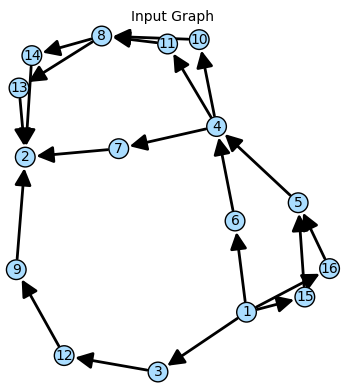


--- 2. SPQR Tree Decomposition ---


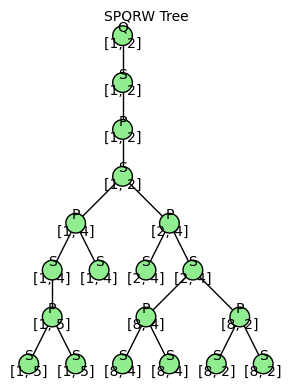


--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---


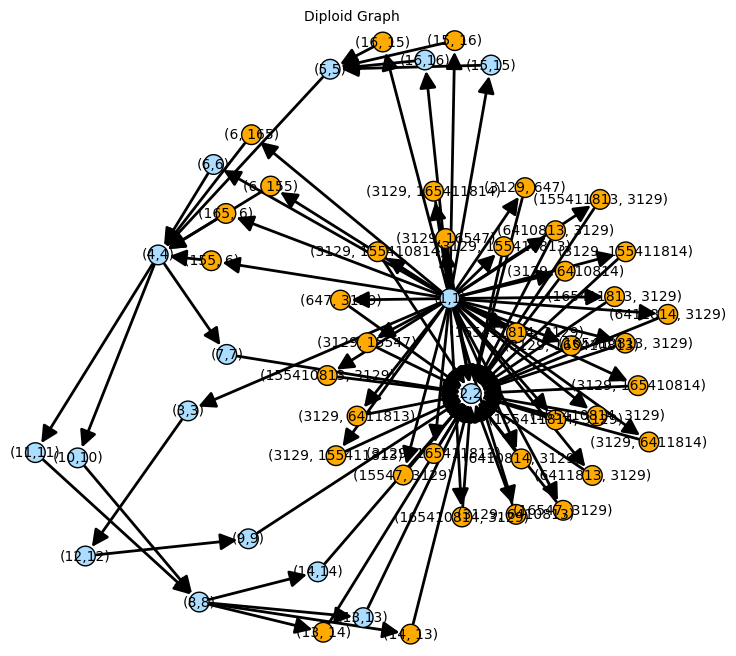


        GRAPH SIZE REPORT        
Input Stats: 16 nodes, 21 edges
Diploid Stats: 54 nodes, 97 edges
Node Expansion: 3.38x
Edge Expansion: 4.62x


In [19]:
# ============================================================
# 1. IMPORTS
# ============================================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import traceback
import sys
import random

# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def get_shared_vertices(g1, g2):
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

def find_all_paths(G, s, t):
    """Return all simple paths from s to t (length > 1)."""
    paths = []
    for p in G.all_paths(s, t):
        if len(p) > 1:
            paths.append(tuple(p))
    return paths

def format_path_label(path):
    """
    Converts path tuple to string label.
    (2, 5, 6, 7, 10) -> "567"
    Direct edge (2, 10) -> "-"
    """
    internals = path[1:-1]
    if not internals:
        return "-"
    return "".join(str(n) for n in internals)

# ============================================================
# 3. SPQR DECOMPOSITION
# ============================================================
def analyze_canonical_spqr(G, source_node, sink_node):
    G_multi = Graph(G.to_undirected(), multiedges=True)
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label="REFERENCE_EDGE")

    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()

    # Locate root
    root_component = None
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        if source_node in subgraph and sink_node in subgraph:
            if subgraph.has_edge(source_node, sink_node):
                root_component = node; break
    if root_component is None:
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                root_component = node; break
    if root_component is None: raise ValueError("Root not found.")

    # Build tree
    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    queue = [(root_component, root_q)]; visited = {root_component}; all_nodes = [root_q]; counter = 0

    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        final_type = curr_type
        if curr_type == 'R' and curr_subgraph.order() > 2: final_type = 'W'

        if parent_display['id'] == 'ROOT_Q': terms = [source_node, sink_node]
        else:
            parent_sage_obj = next(n['sage_obj'] for n in all_nodes if n['id'] == parent_display['id'])
            terms = get_shared_vertices(curr_subgraph, parent_sage_obj)
            if not terms: terms = [source_node, sink_node]

        node_id = f"{final_type}_{counter}"
        counter += 1
        display_node = {'id': node_id, 'type': final_type, 'terminals': terms, 'sage_obj': curr_subgraph, 'parent_id': parent_display['id']}
        all_nodes.append(display_node)

        for nbr in T.neighbor_iterator(curr_sage):
            if nbr not in visited:
                visited.add(nbr); queue.append((nbr, display_node))
    return all_nodes

# ============================================================
# 4. DIPLOID CONSTRUCTION (WITH CUSTOM LABELS)
# ============================================================
def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    display_labels = {} 

    # 1. Backbone
    for v in G.vertices(sort=False): 
        GD.add_vertex((v, v))
        display_labels[(v, v)] = f"({v},{v})"

    for u, v, l in G.edges(sort=False): 
        GD.add_edge((u, u), (v, v), label="backbone")

    # 2. Expansion
    for node in spqr_nodes:
        if node["type"] not in ["P", "W"]: continue
        s, t = node["terminals"]
        all_paths = find_all_paths(G, s, t)
        
        if len(all_paths) < 2: continue

        for i in range(len(all_paths)):
            P1 = all_paths[i]
            set_p1 = set(P1[1:-1])
            for j in range(len(all_paths)):
                if i == j: continue
                P2 = all_paths[j]
                set_p2 = set(P2[1:-1])
                
                if set_p1.isdisjoint(set_p2):
                    pair_id = hash((P1, P2)) % 100000
                    het_node = f"Het_{node['type']}_{pair_id}"
                    
                    GD.add_vertex(het_node)
                    GD.add_edge((s, s), het_node)
                    GD.add_edge(het_node, (t, t))

                    str_p1 = format_path_label(P1)
                    str_p2 = format_path_label(P2)
                    display_labels[het_node] = f"({str_p1}, {str_p2})"

    return GD, display_labels

# ============================================================
# 5. VISUALIZATION FUNCTIONS
# ============================================================
def visualize_input_graph(G):
    print("\n--- 1. Input Haploid Graph (Nested SP) ---")
    G.show(layout="spring", vertex_colors={"#aaddff": G.vertices(sort=False)}, title="Input Graph", figsize=6)

def visualize_spqr_tree(spqr_nodes):
    VizTree = Graph()
    labels = {}
    for node in spqr_nodes:
        uid = node["id"]
        VizTree.add_vertex(uid)
        labels[uid] = f"{node['type']}\n{node['terminals']}"
        
    for node in spqr_nodes:
        pid = node.get('parent_id')
        if pid: VizTree.add_edge(pid, node['id'])

    print("\n--- 2. SPQR Tree Decomposition ---")
    # Using GREEN for all nodes as requested
    VizTree.show(layout='tree', tree_root='ROOT_Q', vertex_colors={"#90ee90": VizTree.vertices(sort=False)}, vertex_labels=labels, title="SPQRW Tree", figsize=6)

def visualize_diploid_graph(GD, custom_labels):
    colors = {"#aaddff": [], "#ffaa00": []}
    for v in GD.vertices(sort=False):
        if isinstance(v, tuple) or isinstance(v, int):
            colors["#aaddff"].append(v) # Backbone (Blue)
        else:
            colors["#ffaa00"].append(v) # Heterozygous (Orange)

    print("\n--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---")
    GD.show(layout="spring", vertex_colors=colors, vertex_labels=custom_labels, title="Diploid Graph", figsize=10)

# ============================================================
# 6. RANDOM NESTED SP GENERATOR
# ============================================================
def generate_nested_sp_dag(num_operations=10):
    """Generates a random Series-Parallel DAG by iteratively splitting edges."""
    G = DiGraph()
    G.add_edge(1, 2) # Start with root edge
    max_node = 2
    
    for _ in range(num_operations):
        edges = list(G.edges(sort=False, labels=False))
        if not edges: break
        
        # Pick random edge to split
        u, v = random.choice(edges)
        
        # Bias towards Parallel (Bubbles) to create complexity
        op = random.choice(["series", "parallel", "parallel"]) 
        
        if op == "series":
            # u->v becomes u->w->v
            max_node += 1
            w = max_node
            G.delete_edge(u, v)
            G.add_edge(u, w); G.add_edge(w, v)
            
        elif op == "parallel":
            # u->v becomes bubble (u->m1->v, u->m2->v)
            G.delete_edge(u, v)
            max_node += 1; m1 = max_node
            max_node += 1; m2 = max_node
            G.add_edge(u, m1); G.add_edge(m1, v)
            G.add_edge(u, m2); G.add_edge(m2, v)
            
    return G, 1, 2 # Graph, Source, Sink

# ============================================================
# 7. EXECUTION
# ============================================================
print(">>> PIPELINE STARTED: Random Nested SP Graph")

# Create graph with 8 iterations of nesting (complex enough to show hierarchy)
G, src, snk = generate_nested_sp_dag(num_operations=8)

# Note: In SP generation starting from 1->2, the terminals usually remain 1 and 2 
# unless the root edge itself was split. We analyze between global source/sink.
s, t = 1, 2

try:
    # 1. Visuals
    visualize_input_graph(G)

    # 2. Analysis
    spqr_nodes = analyze_canonical_spqr(G, s, t)
    visualize_spqr_tree(spqr_nodes)

    # 3. Diploid Construction
    GD, labels = construct_diploid_graph(G, spqr_nodes)
    visualize_diploid_graph(GD, labels)

    # 4. Report
    print("\n" + "="*40)
    print("        GRAPH SIZE REPORT        ")
    print("="*40)
    print(f"Input Stats: {G.order()} nodes, {G.size()} edges")
    print(f"Diploid Stats: {GD.order()} nodes, {GD.size()} edges")
    if G.order() > 0:
        print(f"Node Expansion: {GD.order() / G.order():.2f}x")
        print(f"Edge Expansion: {GD.size() / G.size():.2f}x")
    print("="*40)

except Exception as e:
    traceback.print_exc()

>>> PIPELINE STARTED: Random Nested SP Graph

--- 1. Input Haploid Graph (Nested SP) ---


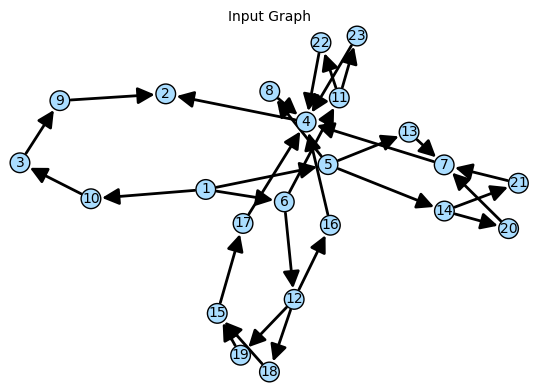


--- 2. SPQR Tree Decomposition ---


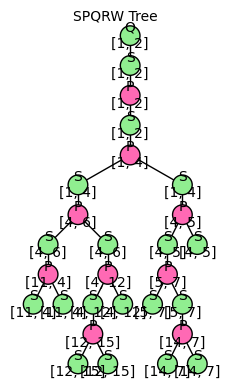


--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---


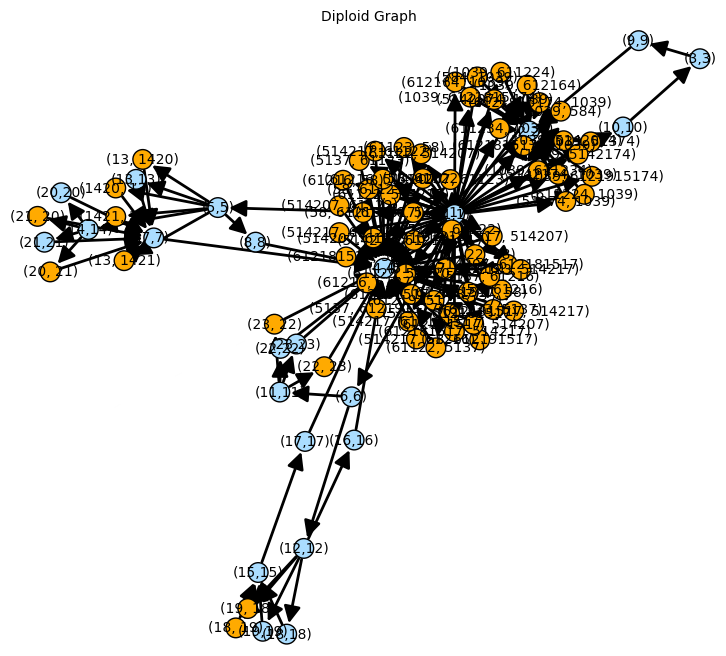


        GRAPH SIZE REPORT        
Input Stats: 23 nodes, 31 edges
Diploid Stats: 91 nodes, 167 edges
Node Expansion: 3.96x
Edge Expansion: 5.39x


In [24]:
# ============================================================
# 1. IMPORTS
# ============================================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import traceback
import sys
import random

# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def get_shared_vertices(g1, g2):
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

def find_all_paths(G, s, t):
    """Return all simple paths from s to t (length > 1)."""
    paths = []
    # Limit path finding for safety
    for p in G.all_paths(s, t):
        if len(p) > 1:
            paths.append(tuple(p))
        if len(paths) > 50: break
    return paths

def format_path_label(path):
    """
    Converts path tuple to string label.
    (2, 5, 6, 7, 10) -> "567"
    Direct edge (2, 10) -> "-"
    """
    internals = path[1:-1]
    if not internals:
        return "-"
    return "".join(str(n) for n in internals)

# ============================================================
# 3. SPQR DECOMPOSITION
# ============================================================
def analyze_canonical_spqr(G, source_node, sink_node):
    G_multi = Graph(G.to_undirected(), multiedges=True)
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label="REFERENCE_EDGE")

    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()

    root = None
    for node in T.vertices(sort=False):
        tp, sub = node
        if source_node in sub and sink_node in sub and sub.has_edge(source_node, sink_node):
            root = node; break
    if root is None:
        for node in T.vertices(sort=False):
            tp, sub = node
            if source_node in sub and sink_node in sub:
                root = node; break
    if root is None: raise ValueError("Root not found.")

    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    queue = [(root, root_q)]; visited = {root}; all_nodes = [root_q]; counter = 0

    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        final_type = curr_type
        if curr_type == 'R' and curr_subgraph.order() > 2: final_type = 'W'

        if parent_display['id'] == 'ROOT_Q': terms = [source_node, sink_node]
        else:
            parent_sage_obj = next(n['sage_obj'] for n in all_nodes if n['id'] == parent_display['id'])
            terms = get_shared_vertices(curr_subgraph, parent_sage_obj)
            if not terms: terms = [source_node, sink_node]

        node_id = f"{final_type}_{counter}"
        counter += 1
        display_node = {'id': node_id, 'type': final_type, 'terminals': terms, 'sage_obj': curr_subgraph, 'parent_id': parent_display['id']}
        all_nodes.append(display_node)

        for nbr in T.neighbor_iterator(curr_sage):
            if nbr not in visited:
                visited.add(nbr); queue.append((nbr, display_node))
    return all_nodes

# ============================================================
# 4. DIPLOID CONSTRUCTION (WITH CUSTOM LABELS)
# ============================================================
def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    display_labels = {} 

    # 1. Backbone
    for v in G.vertices(sort=False): 
        GD.add_vertex((v, v))
        display_labels[(v, v)] = f"({v},{v})"

    for u, v, l in G.edges(sort=False): 
        GD.add_edge((u, u), (v, v), label="backbone")

    # 2. Expansion
    for node in spqr_nodes:
        if node["type"] not in ["P", "W"]: continue
        s, t = node["terminals"]
        all_paths = find_all_paths(G, s, t)
        
        if len(all_paths) < 2: continue

        for i in range(len(all_paths)):
            P1 = all_paths[i]
            set_p1 = set(P1[1:-1])
            for j in range(len(all_paths)):
                if i == j: continue
                P2 = all_paths[j]
                set_p2 = set(P2[1:-1])
                
                if set_p1.isdisjoint(set_p2):
                    pair_id = hash((P1, P2)) % 100000
                    het_node = f"Het_{node['type']}_{pair_id}"
                    
                    GD.add_vertex(het_node)
                    GD.add_edge((s, s), het_node)
                    GD.add_edge(het_node, (t, t))

                    str_p1 = format_path_label(P1)
                    str_p2 = format_path_label(P2)
                    display_labels[het_node] = f"({str_p1}, {str_p2})"

    return GD, display_labels

# ============================================================
# 5. VISUALIZATION FUNCTIONS
# ============================================================
def visualize_input_graph(G):
    print("\n--- 1. Input Haploid Graph (Nested SP) ---")
    # All Blue Vertices
    G.show(layout="spring", vertex_colors={"#aaddff": G.vertices(sort=False)}, title="Input Graph", figsize=6)

def visualize_spqr_tree(spqr_nodes):
    VizTree = Graph()
    labels = {}
    
    # Colors: P=Pink, Others=Green
    colors = {'#FF69B4': [], '#90ee90': []}
    
    for node in spqr_nodes:
        uid = node["id"]
        ntype = node["type"]
        
        VizTree.add_vertex(uid)
        labels[uid] = f"{ntype}\n{node['terminals']}"
        
        if ntype == 'P': colors['#FF69B4'].append(uid)
        else: colors['#90ee90'].append(uid)
        
    for node in spqr_nodes:
        pid = node.get('parent_id')
        if pid: VizTree.add_edge(pid, node['id'])

    print("\n--- 2. SPQR Tree Decomposition ---")
    VizTree.show(layout='tree', tree_root='ROOT_Q', vertex_colors=colors, vertex_labels=labels, title="SPQRW Tree", figsize=6)

def visualize_diploid_graph(GD, custom_labels):
    colors = {"#aaddff": [], "#ffaa00": []}
    for v in GD.vertices(sort=False):
        if isinstance(v, tuple) or isinstance(v, int):
            colors["#aaddff"].append(v) # Backbone (Blue)
        else:
            colors["#ffaa00"].append(v) # Heterozygous (Orange)

    print("\n--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---")
    GD.show(layout="spring", vertex_colors=colors, vertex_labels=custom_labels, title="Diploid Graph", figsize=10)

# ============================================================
# 6. RANDOM NESTED SP GENERATOR
# ============================================================
def generate_nested_sp_dag(num_operations=10):
    """Generates a random Series-Parallel DAG by iteratively splitting edges."""
    G = DiGraph()
    G.add_edge(1, 2) 
    max_node = 2
    
    for _ in range(num_operations):
        edges = list(G.edges(sort=False, labels=False))
        if not edges: break
        
        u, v = random.choice(edges)
        op = random.choice(["series", "parallel", "parallel"]) 
        
        if op == "series":
            max_node += 1
            w = max_node
            G.delete_edge(u, v)
            G.add_edge(u, w); G.add_edge(w, v)
            
        elif op == "parallel":
            G.delete_edge(u, v)
            max_node += 1; m1 = max_node
            max_node += 1; m2 = max_node
            G.add_edge(u, m1); G.add_edge(m1, v)
            G.add_edge(u, m2); G.add_edge(m2, v)
            
    return G, 1, 2 

# ============================================================
# 7. EXECUTION
# ============================================================
print(">>> PIPELINE STARTED: Random Nested SP Graph")

# Create graph with 12 iterations (Good balance of complexity)
G, src, snk = generate_nested_sp_dag(num_operations=12)
s, t = 1, 2

try:
    # 1. Visuals
    visualize_input_graph(G)

    # 2. Analysis
    spqr_nodes = analyze_canonical_spqr(G, s, t)
    visualize_spqr_tree(spqr_nodes)

    # 3. Diploid Construction
    GD, labels = construct_diploid_graph(G, spqr_nodes)
    visualize_diploid_graph(GD, labels)

    # 4. Report
    print("\n" + "="*40)
    print("        GRAPH SIZE REPORT        ")
    print("="*40)
    print(f"Input Stats: {G.order()} nodes, {G.size()} edges")
    print(f"Diploid Stats: {GD.order()} nodes, {GD.size()} edges")
    if G.order() > 0:
        print(f"Node Expansion: {GD.order() / G.order():.2f}x")
        print(f"Edge Expansion: {GD.size() / G.size():.2f}x")
    print("="*40)

except Exception as e:
    traceback.print_exc()

>>> PIPELINE STARTED: Complex Nested SP Graph
Generated Graph: 33 nodes, 43 edges.
Terminals: (1, 2)

--- 1. Input Haploid Graph (Complex Nested SP) ---


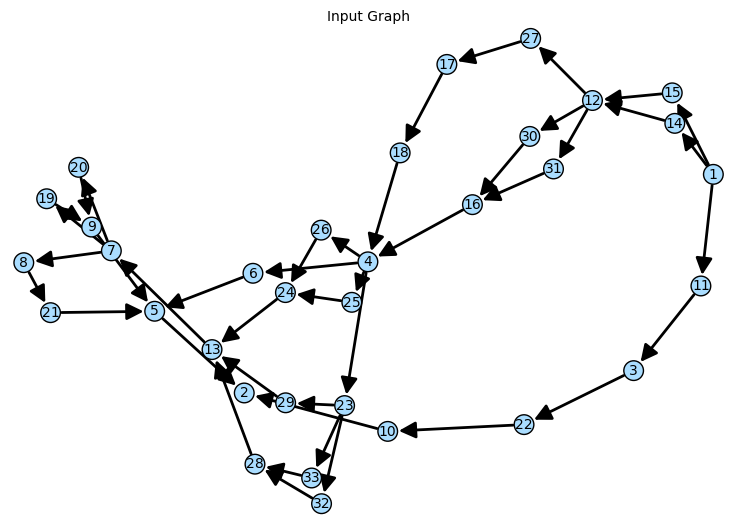


--- 2. SPQR Tree Decomposition ---


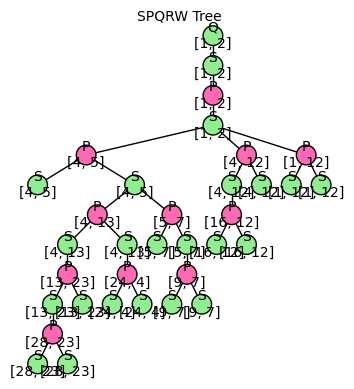


--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---


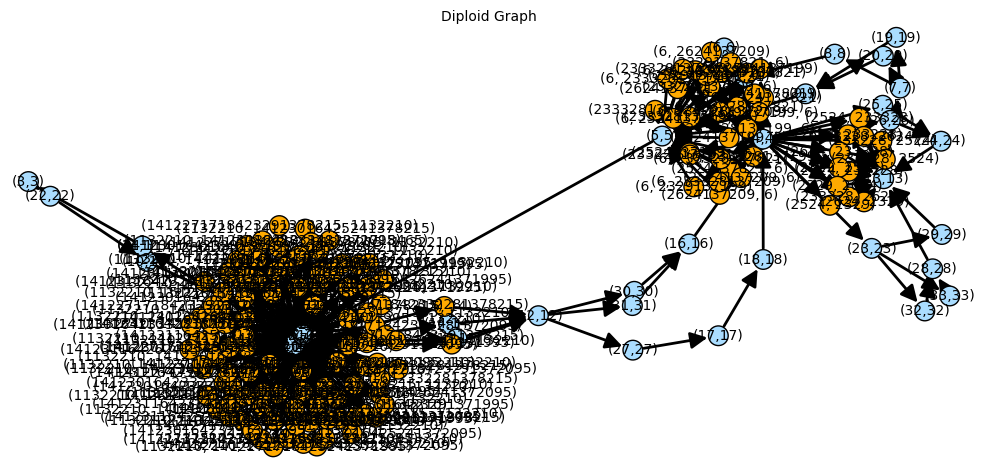


        GRAPH SIZE REPORT        
Haploid Graph (G): 33 nodes, 43 edges
Diploid Graph (GD): 177 nodes, 331 edges
Node Expansion: 5.36x
Edge Expansion: 7.70x


In [27]:
# ==========================================
# 1. GENERATOR: COMPLEX NESTED SP GRAPH
# ==========================================
from sage.all import * # Import Sage first
import random            # Import Python random SECOND to verify it isn't overwritten
import traceback

def generate_complex_nested_sp_graph(num_operations=15, serial_prob=0.3):
    """
    Generates a random Series-Parallel (SP) DAG by iteratively expanding edges.
    """
    # 1. Start with a single edge base graph: 1 -> 2
    G = DiGraph()
    source = 1
    sink = 2
    G.add_edge(source, sink)
    
    # Track the next available node ID
    next_node_id = 3
    
    for i in range(num_operations):
        # Get list of all current edges
        edges = list(G.edges(sort=False, labels=False))
        if not edges:
            break
            
        # Pick a random edge to expand: u -> v
        u, v = random.choice(edges)
        
        # Decide on expansion type: Series or Parallel
        if random.random() < serial_prob:
            # --- SERIES EXPANSION ---
            w = next_node_id
            next_node_id += 1
            
            G.delete_edge(u, v)
            G.add_edge(u, w)
            G.add_edge(w, v)
            
        else:
            # --- PARALLEL EXPANSION (Bubble) ---
            m1 = next_node_id
            m2 = next_node_id + 1
            next_node_id += 2
            
            G.delete_edge(u, v)
            
            # Add Path 1
            G.add_edge(u, m1); G.add_edge(m1, v)
            # Add Path 2
            G.add_edge(u, m2); G.add_edge(m2, v)

    return G, source, sink

# ==========================================
# 2. EXECUTION PIPELINE
# ==========================================
print(">>> PIPELINE STARTED: Complex Nested SP Graph")

# 1. Generate the graph (20 operations for complexity)
G_complex, s, t = generate_complex_nested_sp_graph(num_operations=20, serial_prob=0.3)

print(f"Generated Graph: {G_complex.order()} nodes, {G_complex.size()} edges.")
print(f"Terminals: ({s}, {t})")

try:
    # 2. Visualize Input Graph (Blue)
    print("\n--- 1. Input Haploid Graph (Complex Nested SP) ---")
    G_complex.show(layout='spring', vertex_colors={"#aaddff": G_complex.vertices(sort=False)}, figsize=8, title="Input Graph")

    # 3. SPQR Analysis
    # (Assumes analyze_canonical_spqr is defined in your previous cell)
    spqr_nodes = analyze_canonical_spqr(G_complex, s, t)
    
    # 4. Visualize SPQR Tree (Green, P=Pink)
    # (Assumes visualize_spqr_tree is defined)
    visualize_spqr_tree(spqr_nodes)

    # 5. Diploid Construction
    # (Assumes construct_diploid_graph is defined)
    GD, labels = construct_diploid_graph(G_complex, spqr_nodes)
    
    # 6. Visualize Diploid Graph (Blue/Orange with Labels)
    # (Assumes visualize_diploid_graph is defined)
    visualize_diploid_graph(GD, labels)

    # 7. Size Report
    V_in = G_complex.order()
    V_out = GD.order()
    E_in = G_complex.size()
    E_out = GD.size()
    
    print("\n" + "="*40)
    print("        GRAPH SIZE REPORT        ")
    print("="*40)
    print(f"Haploid Graph (G): {V_in} nodes, {E_in} edges")
    print(f"Diploid Graph (GD): {V_out} nodes, {E_out} edges")
    
    if V_in > 0:
        print(f"Node Expansion: {V_out / V_in:.2f}x")
        print(f"Edge Expansion: {E_out / E_in:.2f}x")
    print("="*40)

except Exception as e:
    import traceback
    traceback.print_exc()

>>> PIPELINE STARTED: Complex Nested SP Graph
Generated Graph: 37 nodes, 51 edges.

--- 1. Input Haploid Graph (Nested SP) ---


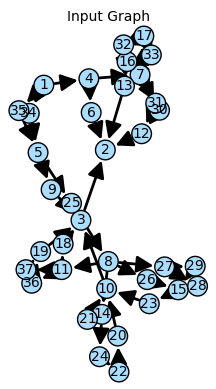


--- 2. SPQR Tree Decomposition ---


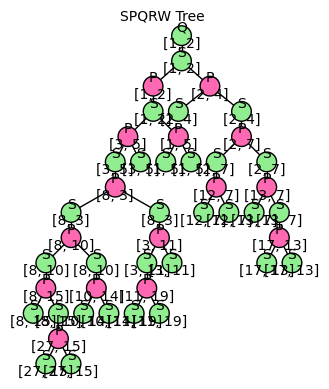


--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---


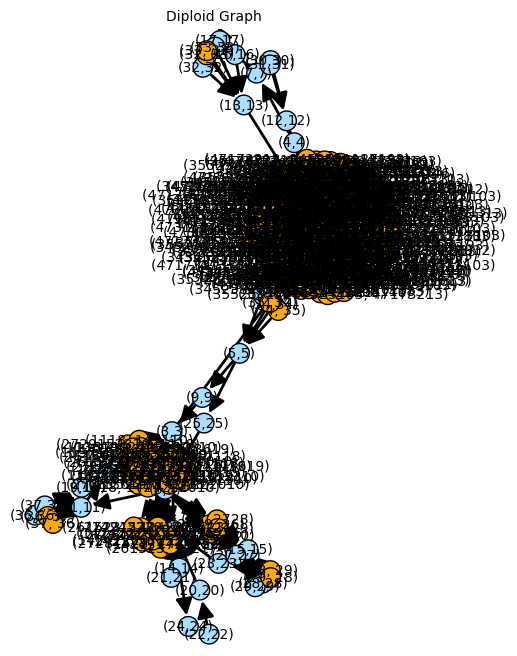


        GRAPH SIZE REPORT        
Input Stats: 37 nodes, 51 edges
Diploid Stats: 307 nodes, 591 edges
Node Expansion: 8.30x
Edge Expansion: 11.59x


In [28]:
# ============================================================
# 1. IMPORTS
# ============================================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import traceback
import sys
import random

# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def get_shared_vertices(g1, g2):
    """Return vertices shared between two Sage graph objects."""
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

def find_all_paths(G, s, t):
    """Return all simple paths from s to t (length > 1)."""
    paths = []
    # Safety limit for huge random graphs
    count = 0
    for p in G.all_paths(s, t):
        if len(p) > 1:
            paths.append(tuple(p))
            count += 1
        if count > 50: break
    return paths

def format_path_label(path):
    """Converts path tuple to string label (e.g., '567')."""
    internals = path[1:-1]
    if not internals:
        return "-"
    return "".join(str(n) for n in internals)

# ============================================================
# 3. ALGORITHM 2: SPQRW DECOMPOSITION
# ============================================================
def analyze_canonical_spqr(G, source_node, sink_node):
    G_multi = Graph(G.to_undirected(), multiedges=True)
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label="REFERENCE_EDGE")

    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()

    # Locate root
    root_component = None
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        if source_node in subgraph and sink_node in subgraph:
            if subgraph.has_edge(source_node, sink_node):
                root_component = node; break
    if root_component is None:
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                root_component = node; break
    if root_component is None: raise ValueError("Root not found.")

    # Build tree
    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    queue = [(root_component, root_q)]; visited = {root_component}; all_nodes = [root_q]; counter = 0

    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        final_type = curr_type
        if curr_type == 'R' and curr_subgraph.order() > 2: final_type = 'W'

        if parent_display['id'] == 'ROOT_Q': terms = [source_node, sink_node]
        else:
            parent_sage_obj = next(n['sage_obj'] for n in all_nodes if n['id'] == parent_display['id'])
            terms = get_shared_vertices(curr_subgraph, parent_sage_obj)
            if not terms: terms = [source_node, sink_node]

        node_id = f"{final_type}_{counter}"
        counter += 1
        display_node = {'id': node_id, 'type': final_type, 'terminals': terms, 'sage_obj': curr_subgraph, 'parent_id': parent_display['id']}
        all_nodes.append(display_node)

        for nbr in T.neighbor_iterator(curr_sage):
            if nbr not in visited:
                visited.add(nbr); queue.append((nbr, display_node))
    return all_nodes

# ============================================================
# 4. ALGORITHM 3: DIPLOID CONSTRUCTION (Extension Logic)
# ============================================================
def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    display_labels = {} 

    # 1. Backbone
    for v in G.vertices(sort=False): 
        GD.add_vertex((v, v))
        display_labels[(v, v)] = f"({v},{v})"

    for u, v, l in G.edges(sort=False): 
        GD.add_edge((u, u), (v, v), label="backbone")

    # 2. Expansion
    for node in spqr_nodes:
        if node["type"] not in ["P", "W"]: continue
        s, t = node["terminals"]
        
        # --- P-NODE EXTENSION LOGIC IS HERE ---
        all_paths = find_all_paths(G, s, t)
        if len(all_paths) < 2: continue

        for i in range(len(all_paths)):
            P1 = all_paths[i]
            set_p1 = set(P1[1:-1])
            for j in range(len(all_paths)):
                if i == j: continue
                P2 = all_paths[j]
                set_p2 = set(P2[1:-1])
                
                # Disjoint Check
                if set_p1.isdisjoint(set_p2):
                    pair_id = hash((P1, P2)) % 100000
                    het_node = f"Het_{node['type']}_{pair_id}"
                    
                    GD.add_vertex(het_node)
                    GD.add_edge((s, s), het_node)
                    GD.add_edge(het_node, (t, t))

                    # Custom Label
                    str_p1 = format_path_label(P1)
                    str_p2 = format_path_label(P2)
                    display_labels[het_node] = f"({str_p1}, {str_p2})"

    return GD, display_labels

# ============================================================
# 5. VISUALIZATION FUNCTIONS
# ============================================================
def visualize_input_graph(G):
    print("\n--- 1. Input Haploid Graph (Nested SP) ---")
    G.show(layout="spring", vertex_colors={"#aaddff": G.vertices(sort=False)}, title="Input Graph", figsize=6)

def visualize_spqr_tree(spqr_nodes):
    VizTree = Graph()
    labels = {}
    # Colors: P=Pink (#FF69B4), Others=Green (#90ee90)
    colors = {'#FF69B4': [], '#90ee90': []}
    
    for node in spqr_nodes:
        uid = node["id"]
        ntype = node["type"]
        VizTree.add_vertex(uid)
        labels[uid] = f"{ntype}\n{node['terminals']}"
        
        if ntype == 'P': colors['#FF69B4'].append(uid)
        else: colors['#90ee90'].append(uid)
        
    for node in spqr_nodes:
        pid = node.get('parent_id')
        if pid: VizTree.add_edge(pid, node['id'])

    print("\n--- 2. SPQR Tree Decomposition ---")
    VizTree.show(layout='tree', tree_root='ROOT_Q', vertex_colors=colors, vertex_labels=labels, title="SPQRW Tree", figsize=6)

def visualize_diploid_graph(GD, custom_labels):
    colors = {"#aaddff": [], "#ffaa00": []}
    for v in GD.vertices(sort=False):
        if isinstance(v, tuple) or isinstance(v, int):
            colors["#aaddff"].append(v) # Backbone (Blue)
        else:
            colors["#ffaa00"].append(v) # Heterozygous (Orange)

    print("\n--- 3. Diploid Graph (Blue=Homo, Orange=Het) ---")
    GD.show(layout="spring", vertex_colors=colors, vertex_labels=custom_labels, title="Diploid Graph", figsize=10)

# ============================================================
# 6. NESTED SP GENERATOR
# ============================================================
def generate_complex_nested_sp_graph(num_operations=15, serial_prob=0.3):
    G = DiGraph()
    source = 1; sink = 2
    G.add_edge(source, sink)
    next_node_id = 3
    
    for i in range(num_operations):
        edges = list(G.edges(sort=False, labels=False))
        if not edges: break
        u, v = random.choice(edges)
        
        if random.random() < serial_prob:
            w = next_node_id; next_node_id += 1
            G.delete_edge(u, v)
            G.add_edge(u, w); G.add_edge(w, v)
        else:
            m1 = next_node_id; m2 = next_node_id + 1; next_node_id += 2
            G.delete_edge(u, v)
            G.add_edge(u, m1); G.add_edge(m1, v)
            G.add_edge(u, m2); G.add_edge(m2, v)
    return G, source, sink

# ============================================================
# 7. EXECUTION PIPELINE
# ============================================================
print(">>> PIPELINE STARTED: Complex Nested SP Graph")

# Generate Graph (20 operations for robust nesting)
G_complex, s, t = generate_complex_nested_sp_graph(num_operations=20, serial_prob=0.3)

print(f"Generated Graph: {G_complex.order()} nodes, {G_complex.size()} edges.")

try:
    # 1. Visuals
    visualize_input_graph(G_complex)

    # 2. Analysis
    spqr_nodes = analyze_canonical_spqr(G_complex, s, t)
    visualize_spqr_tree(spqr_nodes)

    # 3. Diploid Construction
    GD, labels = construct_diploid_graph(G_complex, spqr_nodes)
    visualize_diploid_graph(GD, labels)

    # 4. Report
    V_in = G_complex.order()
    V_out = GD.order()
    E_in = G_complex.size()
    E_out = GD.size()
    
    print("\n" + "="*40)
    print("        GRAPH SIZE REPORT        ")
    print("="*40)
    print(f"Input Stats: {V_in} nodes, {E_in} edges")
    print(f"Diploid Stats: {V_out} nodes, {E_out} edges")
    if V_in > 0:
        print(f"Node Expansion: {V_out / V_in:.2f}x")
        print(f"Edge Expansion: {E_out / E_in:.2f}x")
    print("="*40)

except Exception as e:
    traceback.print_exc()